In [18]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df
from src.analysis import score_fallacy_classification, get_accuracies, add_llm_info
from src.plot import plot_accuracies
import seaborn as sns
import pandas as pd

sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fallacy Classification Analysis

## Experiment 4: Fallacy Classification with zero-shot Prompt

In [19]:
df_fallacies_e4 = get_fallacy_df('data/fallacies_e4.csv')

# GPT-4 responses are incomplete and API usage is too expensive to get all responses.
# We use about 2300 input tokens per classification prompt, which means 5.336M tokens for 2320 samples.
# For classification with GPT-4 alone, the total cost would be $160.

# https://openai.com/api/pricing/
# gpt-4:                    $30.00 / 1M tokens
# gpt-4o-mini-2024-07-18:   $0.150 / 1M input tokens
# gpt-4o-2024-08-06:        $2.50 / 1M input tokens
# o1-preview-2024-09-12:    $15.00 / 1M input tokens

df_fallacies_e4.drop(columns='gpt_4_response', inplace=True)

df_fallacies_e4.head()

[2024-10-23 12:03:52] Loaded existing fallacy dataframe from data/fallacies_e4.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4o_mini_response,claude_3_5_sonnet_response,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_8b_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Denying the Antecedent,Argument from Silence,Argument from Silence
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,Argument from Silence,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence


In [20]:
score_fallacy_classification(df_fallacies_e4)

df_fallacies_e4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          2320 non-null   object
 1   entity                        2320 non-null   object
 2   fallacy                       2320 non-null   object
 3   label                         2320 non-null   int64 
 4   category                      2320 non-null   object
 5   subcategory                   2320 non-null   object
 6   gpt_4o_response               2320 non-null   object
 7   gpt_4o_mini_response          2320 non-null   object
 8   claude_3_5_sonnet_response    2320 non-null   object
 9   claude_3_haiku_response       2320 non-null   object
 10  gemini_1_5_pro_response       2320 non-null   object
 11  gemini_1_5_flash_8b_response  2320 non-null   object
 12  gpt_4o_score                  2320 non-null   Int64 
 13  gpt_4o_mini_score 

### Global Accuracies

In [21]:
_, df_subcategory_accuracies_e4, df_category_accuracies_e4, df_global_accuracies_e4 = get_accuracies(df_fallacies_e4)

In [22]:
df_global_accuracies_e4 = df_global_accuracies_e4.sort_values('accuracy', ascending=False)
df_global_accuracies_e4

,accuracy
gpt_4o,47.344761
gemini_1_5_pro,41.51332
claude_3_5_sonnet,37.573354
gpt_4o_mini,24.162156
gemini_1_5_flash_8b,18.80397
claude_3_haiku,15.840688


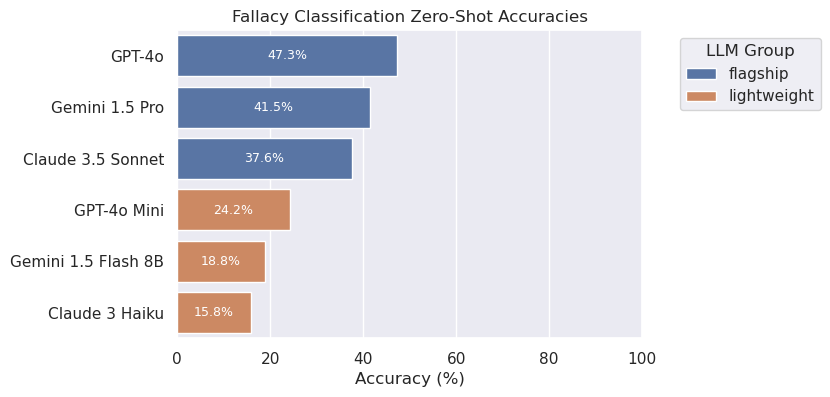

In [23]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e4),
    figsize=(6, 4),
    title='Fallacy Classification Zero-Shot Accuracies',
    hue='llm_group',
    legend_title='LLM Group',
    legend_anchor=(1.4, 1),
    annotate=True,
)

### Fallacy Category Accuracies

In [24]:
df_category_accuracies_e4

category,formal,informal
gpt_4o,52.8125,41.877021
gpt_4o_mini,33.125,15.199312
claude_3_5_sonnet,38.02381,37.122899
claude_3_haiku,16.041667,15.639709
gemini_1_5_pro,44.791667,38.234974
gemini_1_5_flash_8b,25.9375,11.670439


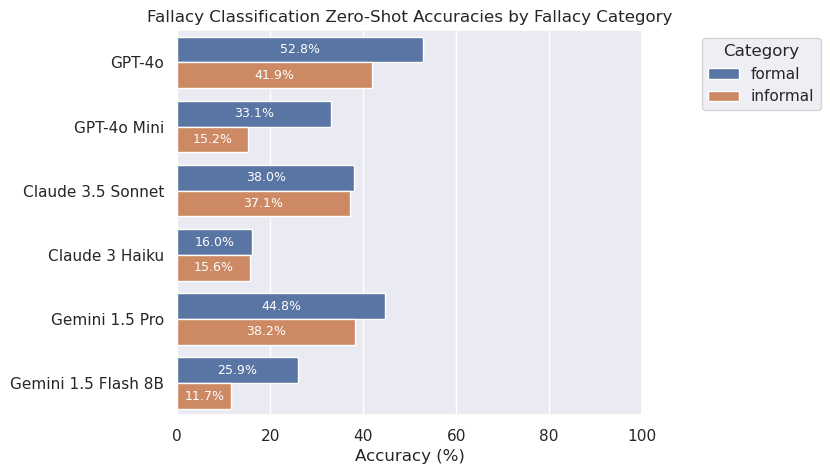

In [25]:
df_category_accuracies_long_e4 = pd.melt(df_category_accuracies_e4, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e4),
    figsize=(6, 5),
    title='Fallacy Classification Zero-Shot Accuracies by Fallacy Category',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
)

In [26]:
df_plot = add_llm_info(df_category_accuracies_long_e4, group=True).groupby(['llm_group', 'category']).mean().reset_index()
df_plot

,llm_group,category,accuracy
0,flagship,formal,45.209325
1,flagship,informal,39.078298
2,lightweight,formal,25.034722
3,lightweight,informal,14.16982


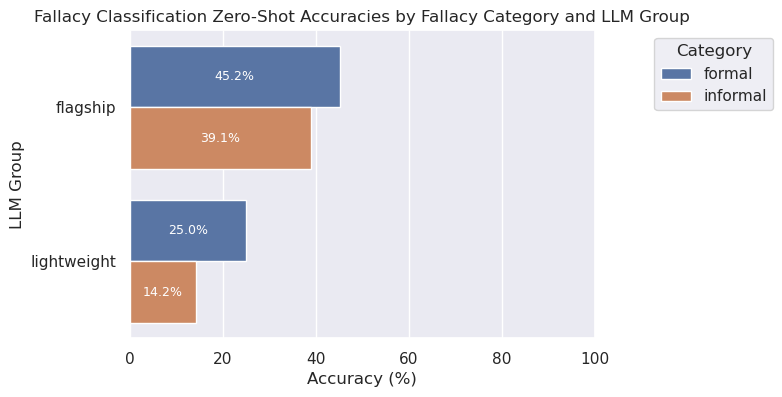

In [27]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Classification Zero-Shot Accuracies by Fallacy Category and LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
)

### Fallacy Subcategory Accuracies

In [28]:
df_subcategory_accuracies_e4

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       57.5          65.0             50.0       38.75   
gpt_4o_mini                  60.0     48.333333         1.666667        22.5   
claude_3_5_sonnet             0.0          74.0        26.666667   51.428571   
claude_3_haiku               20.0     36.666667              0.0         7.5   
gemini_1_5_pro               67.5          55.0        31.666667        25.0   
gemini_1_5_flash_8b          27.5          45.0             15.0       16.25   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o                    44.0                 39.814815     46.666667   
gpt_4o_mini          19.333333                 11.296296      3.333333   
claude_3_5_sonnet    41.818182                 27.234043          40.0   
claude_3_haiku       15.333333                 11.481481     16.666667   
gemini_1_5_pro            46.0                 30.740741          40.0   
gemini_1_5_flash_8b       18.0                 15.555556           0.0   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  36.724138   42.179487  
gpt_4o_mini             17.931034   24.102564  
claude_3_5_sonnet       29.782609   46.779661  
claude_3_haiku          16.896552   17.820513  
gemini_1_5_pro          33.793103   40.641026  
gemini_1_5_flash_8b     11.206897   13.589744

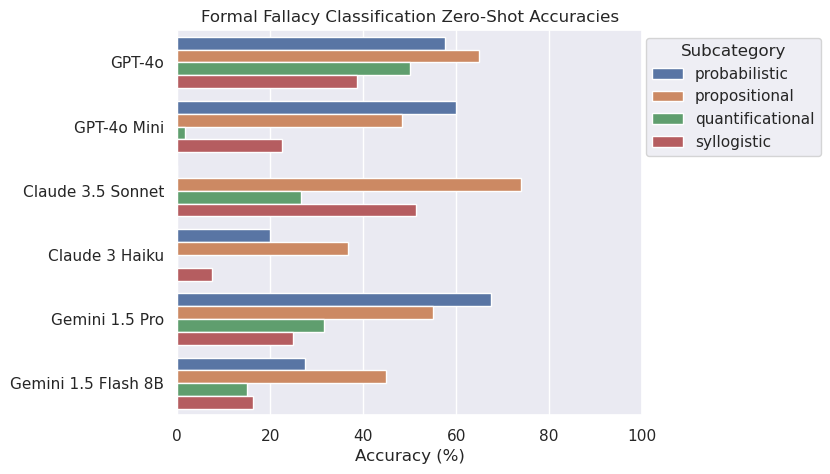

In [29]:
df_subcategory_accuracies_long_e4 = pd.melt(df_subcategory_accuracies_e4, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e4),
    figsize=(6, 5),
    title='Formal Fallacy Classification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
)

In [30]:
df_plot = add_llm_info(df_formal_accuracies_long_e4, group=True).groupby(['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,flagship,formal,probabilistic,41.666667
1,flagship,formal,propositional,64.666667
2,flagship,formal,quantificational,36.111111
3,flagship,formal,syllogistic,38.392857
4,lightweight,formal,probabilistic,35.833333
5,lightweight,formal,propositional,43.333333
6,lightweight,formal,quantificational,5.555556
7,lightweight,formal,syllogistic,15.416667


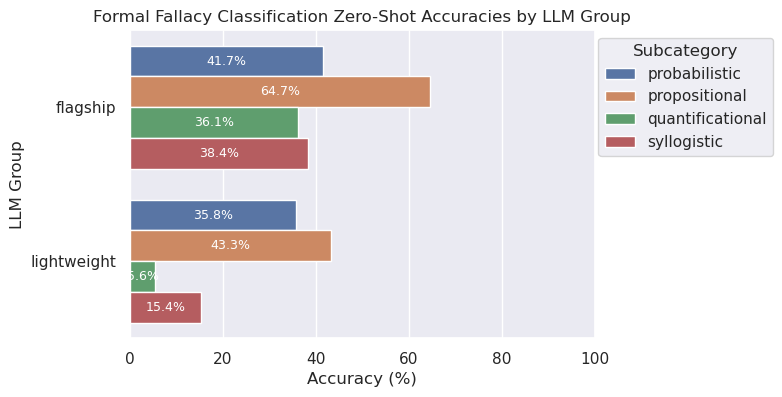

In [31]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Classification Zero-Shot Accuracies by LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=True,
)

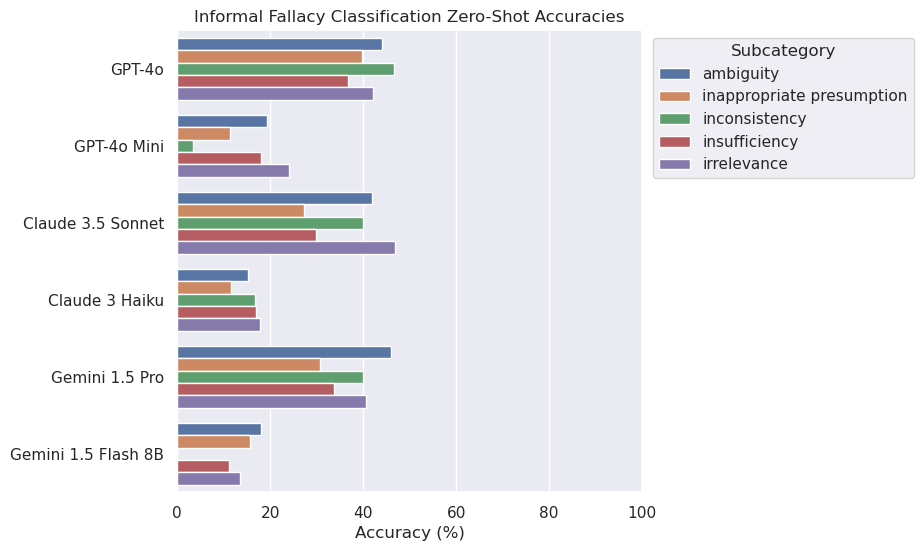

In [32]:
df_informal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e4),
    figsize=(6, 6),
    title='Informal Fallacy Classification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
)

In [33]:
df_plot = add_llm_info(df_informal_accuracies_long_e4, group=True).groupby(['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,flagship,informal,ambiguity,43.939394
1,flagship,informal,inappropriate presumption,32.596533
2,flagship,informal,inconsistency,42.222222
3,flagship,informal,insufficiency,33.433283
4,flagship,informal,irrelevance,43.200058
5,lightweight,informal,ambiguity,17.555556
6,lightweight,informal,inappropriate presumption,12.777778
7,lightweight,informal,inconsistency,6.666667
8,lightweight,informal,insufficiency,15.344828
9,lightweight,informal,irrelevance,18.504274


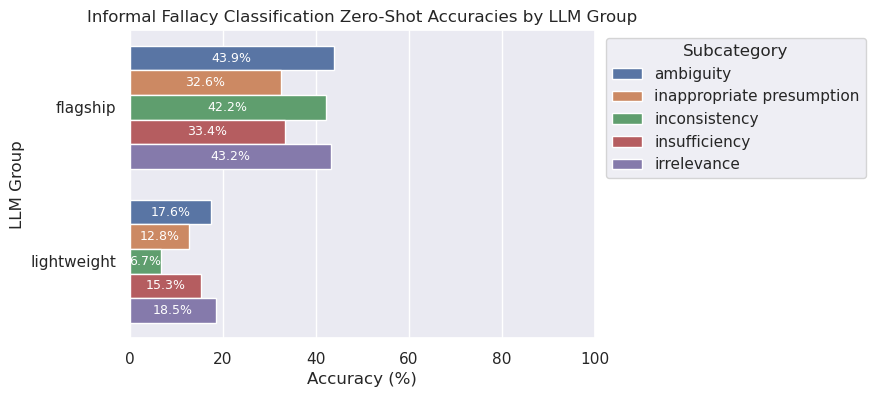

In [34]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Classification Zero-Shot Accuracies by LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=True,
)